# Loading libraries and data

In [87]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import HistGradientBoostingClassifier, HistGradientBoostingRegressor
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from pulp import LpMaximize, LpProblem, LpVariable, lpSum
import warnings  
warnings.filterwarnings('ignore') 
df = pd.read_csv('2021_Green_Taxi_Trip_Data.csv')


# Preprocessing

In [88]:
irrelevant_columns = ['RatecodeID', 'store_and_fwd_flag', 'improvement_surcharge',
                     'ehail_fee', 'mta_tax', 'extra', 'fare_amount',
                     'congestion_surcharge']
df = df.drop(irrelevant_columns, axis=1)
df.info()
df=df.drop_duplicates()
df = df[(df.trip_distance >= 0) & (df.tip_amount >= 0) & (df.tolls_amount >= 0) & (df.total_amount >= 0)]
df['payment_type'] = df['payment_type'].astype(object)
df['trip_type'] = df['trip_type'].astype(object)

df.loc[(df['tip_amount'] > 0) & (df['payment_type'].isnull()), 'payment_type'] = 1
df.loc[df['passenger_count'] > 4, 'payment_type'] = 6
df.loc[df['passenger_count'] > 4, 'trip_type'] = 3

df['pickup_datetime'] = pd.to_datetime(df['lpep_pickup_datetime'], format='%m/%d/%Y %I:%M:%S %p')
df = df[df['pickup_datetime'].dt.year == 2021]

df['pickup_hour'] = df['pickup_datetime'].dt.hour
df['pickup_day'] = df['pickup_datetime'].dt.day
df['pickup_month'] = df['pickup_datetime'].dt.month
df['weekday'] = df['pickup_datetime'].dt.day_name()
weekday_mapping = {
   'Monday': 1,
   'Tuesday': 2,
   'Wednesday': 3,
   'Thursday': 4,
   'Friday': 5,
   'Saturday': 6,
   'Sunday': 7
}
# Apply the mapping to the 'weekday' column
df['weekday'] = df['weekday'].map(weekday_mapping)

df['dropoff_datetime'] = pd.to_datetime(df['lpep_dropoff_datetime'], format='%m/%d/%Y %I:%M:%S %p')
df['dropoff_hour'] = df['dropoff_datetime'].dt.hour
df['dropoff_day'] = df['dropoff_datetime'].dt.day
df['dropoff_month'] = df['dropoff_datetime'].dt.month


df.drop(columns=['lpep_pickup_datetime', 'lpep_dropoff_datetime'], inplace=True)
borough_df = pd.read_csv('Boroughs.csv')
df = df.merge(borough_df[['LocationID', 'Borough']], left_on='PULocationID', right_on='LocationID', how='left')
df.rename(columns={'Borough': 'PU_Borough'}, inplace=True)

df = df.merge(borough_df[['LocationID', 'Borough']], left_on='DOLocationID', right_on='LocationID', how='left')
df.rename(columns={'Borough': 'DO_Borough'}, inplace=True)
df = pd.get_dummies(df, columns=['PU_Borough','DO_Borough'], prefix=['PU','DO'], drop_first=True)
df['pickup_date'] = df['pickup_month'].astype(str) + '-' + df['pickup_day'].astype(str)

# Create the empty_vendor_trips DataFrame 
empty_vendor_trips = df[df['VendorID'].isnull()].groupby(['pickup_date', 'LocationID_x', 'LocationID_y']).size().groupby(level=[1, 2]).mean().unstack(fill_value=0) 


df.dropna(subset=['VendorID'], inplace=True)
df.drop([ 'PULocationID', 'DOLocationID', 'pickup_datetime', 'dropoff_datetime' ,'pickup_date'], axis=1, inplace=True)
print(df.columns)
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns, 'percent_missing': percent_missing})
print(missing_value_df)
df = df.apply(pd.to_numeric, errors='coerce')
for column in df.columns:
   null_percentage = df[column].isnull().mean()
   if 0.05 < null_percentage <= 0.3:
       missing_rows = df[df[column].isnull()]
       complete_rows = df[df[column].notnull()]

       features_to_drop = [column]
       if complete_rows[column].dtype in ['int64', 'float64']:
           model = HistGradientBoostingRegressor()
           model.fit(complete_rows.drop(columns=features_to_drop, errors='ignore'), complete_rows[column])
           predicted_values = model.predict(missing_rows.drop(columns=features_to_drop, errors='ignore'))
           df.loc[df[column].isnull(), column] = predicted_values

       else:
           model = HistGradientBoostingClassifier()
           model.fit(complete_rows.drop(columns=features_to_drop, errors='ignore'), complete_rows[column])
           predicted_values = model.predict(missing_rows.drop(columns=features_to_drop, errors='ignore'))
           df.loc[df[column].isnull(), column] = predicted_values


print(df.LocationID_x.head())
print(df.LocationID_y.head())
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns, 'percent_missing': percent_missing})
print(missing_value_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1068755 entries, 0 to 1068754
Data columns (total 12 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   VendorID               819640 non-null   float64
 1   lpep_pickup_datetime   1068755 non-null  object 
 2   lpep_dropoff_datetime  1068755 non-null  object 
 3   PULocationID           1068755 non-null  int64  
 4   DOLocationID           1068755 non-null  int64  
 5   passenger_count        656321 non-null   float64
 6   trip_distance          1068755 non-null  float64
 7   tip_amount             1068755 non-null  float64
 8   tolls_amount           1068755 non-null  float64
 9   total_amount           1068755 non-null  float64
 10  payment_type           656321 non-null   float64
 11  trip_type              656321 non-null   float64
dtypes: float64(8), int64(2), object(2)
memory usage: 97.8+ MB
Index(['VendorID', 'passenger_count', 'trip_distance', 'tip_amount',

# 1. Create OD matrix

In [89]:
df['PU_Bronx'] = (df.filter(like='PU_').sum(axis=1) == 0).astype(int)
df['DO_Bronx'] = (df.filter(like='DO_').sum(axis=1) == 0).astype(int)
od_matrix = pd.DataFrame(index=df.columns[df.columns.str.startswith('PU_')],
                         columns=df.columns[df.columns.str.startswith('DO_')]).fillna(0)
for pu_col in df.columns[df.columns.str.startswith('PU_')]:
    for do_col in df.columns[df.columns.str.startswith('DO_')]:
        od_matrix.loc[pu_col, do_col] = df[(df[pu_col] == 1) & (df[do_col] == 1)].shape[0]

# Calculate sums for origins and destinations
od_matrix.loc['Total'] = od_matrix.sum()  # Sum for each drop-off column
od_matrix['Total'] = od_matrix.sum(axis=1)  # Sum for each pickup row

## 1.1 Plotting the OD Matrix heatmap

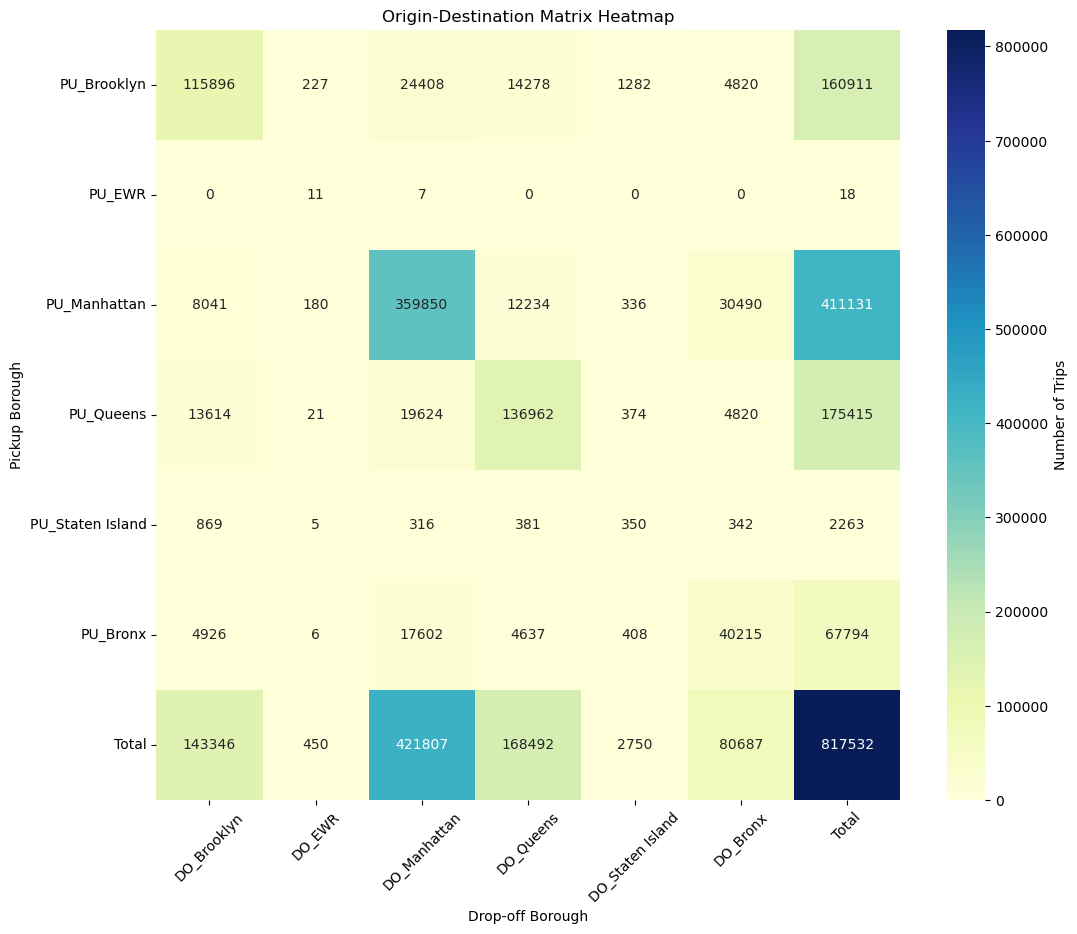

In [90]:
plt.figure(figsize=(12, 10))
sns.heatmap(od_matrix, cmap="YlGnBu", annot=True, fmt=".0f", cbar_kws={"label": "Number of Trips"})
plt.title("Origin-Destination Matrix Heatmap")
plt.xlabel("Drop-off Borough")
plt.ylabel("Pickup Borough")
plt.xticks(rotation=45)
plt.yticks(rotation=0)

plt.show()


## 1.2 Ranking City Blocks by the Highest Percentage of Inter-Block Trips

In [91]:
od_matrix = pd.DataFrame(index=df.columns[df.columns.str.startswith('PU_')],  
                         columns=df.columns[df.columns.str.startswith('DO_')]).fillna(0)  
for pu_col in df.columns[df.columns.str.startswith('PU_')]:  
    for do_col in df.columns[df.columns.str.startswith('DO_')]:  
        od_matrix.loc[pu_col, do_col] = df[(df[pu_col] == 1) & (df[do_col] == 1)].shape[0]  

# محاسبه مجموع کل سفرها  
total_trips = od_matrix.sum().sum()  # مجموع تمامی سفرها در ماتریس  

# محاسبه درصد سفرها در ماتریس  
od_matrix_percent = od_matrix.copy()  
for pu_col in od_matrix_percent.index:  
    for do_col in od_matrix_percent.columns:  
        if od_matrix_percent.loc[pu_col, do_col] > 0:  
            percent = (od_matrix_percent.loc[pu_col, do_col] / total_trips) * 100  
            od_matrix_percent.loc[pu_col, do_col] = percent  
        else:  
            od_matrix_percent.loc[pu_col, do_col] = 0  
# دیکشنری برای نگه‌داری ارتباط بین نام بوره‌ها و شناسه‌هایشان  
borough_ids = {  
    'Bronx': 1,  
    'Brooklyn': 2,  
    'Manhattan': 3,  
    'Queens': 4,  
    'Staten Island': 5  
}  

# ایجاد یک دیکشنری برای جمع‌آوری اطلاعات  
result = []  
for pu_col in od_matrix_percent.index:  
    for do_col in od_matrix_percent.columns:  
        percent = od_matrix_percent.loc[pu_col, do_col]  
        count = od_matrix.loc[pu_col, do_col]  # تعداد سفرها از ماتریس اصلی  
        if percent > 0:  # تنها جفت‌های مثبت  
            pickup_borough = pu_col.split('_')[-1]  # نام بوره  
            dropoff_borough = do_col.split('_')[-1]  # نام بوره  
            
            # ذخیره تمام مقادیر در نتیجه بدون اعمال شرط
            result.append({  
                'Pickup': pickup_borough,  
                'Dropoff': dropoff_borough,  
                'Percentage': percent,  
                'Trip Count': count  # استفاده از دیکشنری برای شناسه  
            })  

# تبدیل به DataFrame
result_df = pd.DataFrame(result)  

# اعمال شرط در سطح DataFrame: فیلتر کردن بخش‌هایی که مبدا و مقصد یکی هستند
result_diff = result_df[result_df['Pickup'] != result_df['Dropoff']]
result_diff = result_diff.sort_values(by='Percentage', ascending=False)  
result_diff.columns = ['Pickup Borough', 'Dropoff Borough', 'Percentage of Trips', 'Number of Trips']  
print("Ranking City Blocks by the Highest Percentage of Inter-Block Trips")
result_diff.index = np.arange(1, len(result_diff)+1)
print(result_diff.head(10))

Ranking City Blocks by the Highest Percentage of Inter-Block Trips
   Pickup Borough Dropoff Borough  Percentage of Trips  Number of Trips
1       Manhattan           Bronx             3.729518            30490
2        Brooklyn       Manhattan             2.985571            24408
3          Queens       Manhattan             2.400395            19624
4           Bronx       Manhattan             2.153066            17602
5        Brooklyn          Queens             1.746476            14278
6          Queens        Brooklyn             1.665256            13614
7       Manhattan          Queens             1.496455            12234
8       Manhattan        Brooklyn             0.983570             8041
9           Bronx        Brooklyn             0.602545             4926
10         Queens           Bronx             0.589579             4820


## 1.3 Ranking City Blocks by the Highest Percentage of Intra-Block Trips

In [92]:
result_same = result_df[result_df['Pickup'] == result_df['Dropoff']]
result_same = result_same.sort_values(by='Percentage', ascending=False)  
result_same.columns = ['Pickup Borough', 'Dropoff Borough', 'Percentage of Trips', 'Number of Trips']  
print("\n Ranking City Blocks by the Highest Percentage of Intra-Block Trips")
result_same.index = np.arange(1, len(result_same)+1)
print(result_same.head(5))


 Ranking City Blocks by the Highest Percentage of Intra-Block Trips
  Pickup Borough Dropoff Borough  Percentage of Trips  Number of Trips
1      Manhattan       Manhattan            44.016626           359850
2         Queens          Queens            16.753106           136962
3       Brooklyn        Brooklyn            14.176326           115896
4          Bronx           Bronx             4.919074            40215
5  Staten Island   Staten Island             0.042812              350


# 2.1 Creating a Demand Matrix

The OD matrix is balanced.


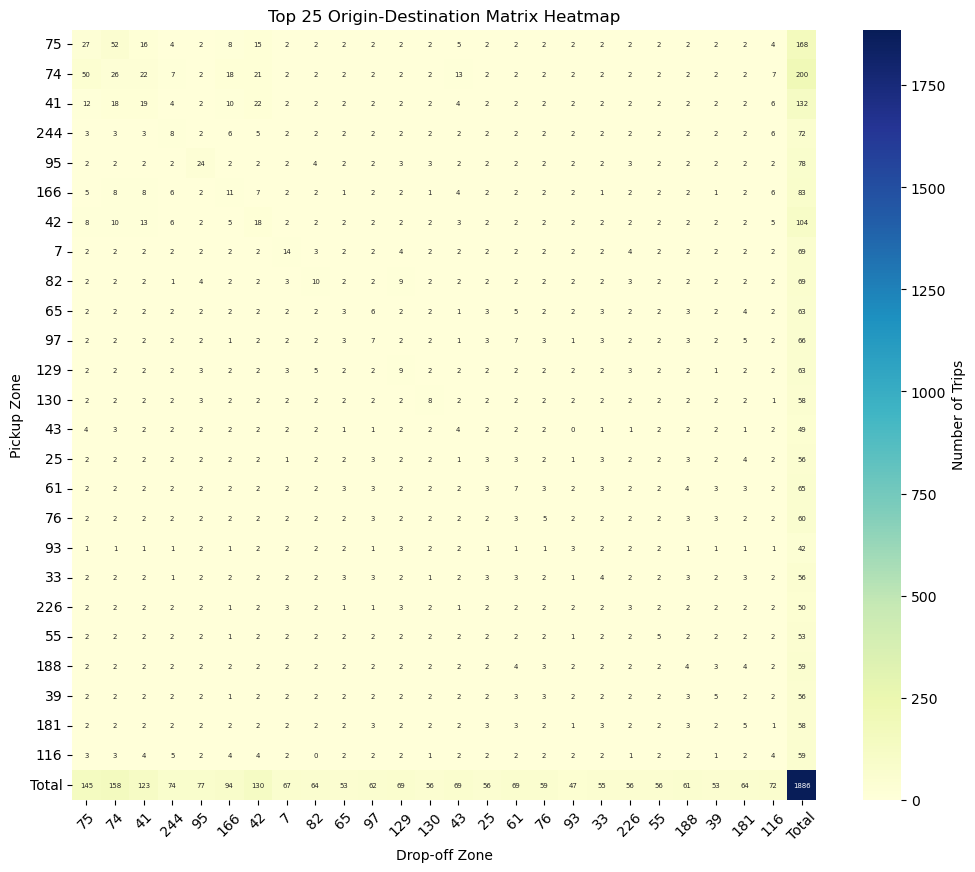

In [93]:
df['pickup_date'] = df['pickup_month'].astype(str) + '-' + df['pickup_day'].astype(str) 
df=df[df['weekday']<6]

# Group by the new pickup_date and the location IDs 
od_matrix = df.groupby(['pickup_date', 'LocationID_x', 'LocationID_y']).size().groupby(level=[1, 2]).mean().unstack(fill_value=0) 

# Get the top 25 zones based on total trips
top_zones = od_matrix.sum(axis=1).nlargest(25).index
filtered_od_matrix = od_matrix.loc[top_zones, top_zones]

empty_vendor_trips = empty_vendor_trips.loc[top_zones,top_zones]
filtered_od_matrix = empty_vendor_trips+ filtered_od_matrix

filtered_od_matrix.loc['Total'] = filtered_od_matrix.sum()  # Sum for each drop-off column
filtered_od_matrix['Total'] = filtered_od_matrix.sum(axis=1)

if filtered_od_matrix['Total'].sum() == filtered_od_matrix.T['Total'].sum():
   print("The OD matrix is balanced.")
else:
   print("The OD matrix is not balanced.")
   
# Plotting the heatmap for the filtered OD matrix
plt.figure(figsize=(12, 10))
sns.heatmap(filtered_od_matrix, cmap="YlGnBu", annot=True, fmt=".0f", cbar_kws={"label": "Number of Trips"},annot_kws={"size": 5})
plt.title("Top 25 Origin-Destination Matrix Heatmap")
plt.xlabel("Drop-off Zone")
plt.ylabel("Pickup Zone")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()


## Creating a matrix for average costs

In [94]:
# Create an empty matrix for average costs  
cost_matrix = pd.DataFrame(index=top_zones, columns=top_zones).fillna(0)  

# Fill the matrix with the average cost for each pair of pickup and dropoff zones  
for pickup_zone in top_zones:  
    for dropoff_zone in top_zones:  
        # Filter data for specific pickup and dropoff zones  
        filtered_data = df[(df['LocationID_x'] == pickup_zone) & (df['LocationID_y'] == dropoff_zone)]  
        # Calculate average cost  
        if not filtered_data.empty:  
            avg_cost = filtered_data['total_amount'].mean()  
        else:  
            avg_cost = 0  # If no data exists, set the value to zero  

        cost_matrix.loc[pickup_zone, dropoff_zone] = avg_cost  

print(cost_matrix)

LocationID_x        75         74         41         244        95   \
LocationID_x                                                          
75             8.082285   8.939057   9.571085  22.645441  46.575789   
74            10.021731   8.587853   8.783413  18.467849  42.432667   
41            10.204878   8.990456   7.626561  16.212075  54.851053   
244           24.516296  18.595549  16.899015   9.924760  57.090323   
95            52.159687  48.093846  57.971333  50.014762  10.101813   
166           13.198754  12.380797   8.968147  16.175090  47.632500   
42            14.141264  10.706106   8.832441  14.581375  47.910000   
7             29.621346  28.246216  34.812222  40.255263  28.886966   
82            35.466176  35.008235  44.123333  44.937778  14.921589   
65            38.398500  41.900000  44.620000  49.878333  36.598462   
97            42.321500  49.321667  48.972727  53.227778  39.850000   
129           34.091538  32.242381  35.646000  45.448000  20.982500   
130   

### Grouping hours of the day

In [95]:
df['pickup_hour'].unique()
def categorize_timegroup(hour):  
    if 0 <= hour <= 7:  
        return 0  # Off-Peak  
    elif 8 <= hour <= 19:  
        return 1  # Peak  
    else:  
        return 2  # Off-Peak  

# Apply the function to create a new column for timegroup  
df['timegroup'] = df['pickup_hour'].apply(categorize_timegroup)  


## Cost Matrix

In [96]:
df_timegp0 = df[df['timegroup'] == 0]  
df_timegp1 = df[df['timegroup'] == 1]  
df_timegp2 = df[df['timegroup'] == 2]  

def mean_pergp(df_gp, col):  
    c_matrix = pd.DataFrame(index=top_zones, columns=top_zones).fillna(0)  
    # Filling the matrix with the average cost for each pair of origin and destination  
    for pickup_zone in top_zones:  
        for dropoff_zone in top_zones:  
            # Filtering data for specific origin and destination zones  
            filtered_data = df_gp[(df_gp['LocationID_x'] == pickup_zone) & (df_gp['LocationID_y'] == dropoff_zone)]  
            # Calculating the average cost  
            if not filtered_data.empty:  
                avg_c = filtered_data[col].mean()  
            else:  
                avg_c = 0  # If no data exists, set the value to zero  
            # Filling the matrix with the average cost value  
            c_matrix.loc[pickup_zone, dropoff_zone] = avg_c  
    return c_matrix  

# Displaying the average cost matrix  
print('1st time group:', mean_pergp(df_timegp0, col='total_amount'))  
print('2nd time group:', mean_pergp(df_timegp1, col='total_amount'))  
print('3rd time group:', mean_pergp(df_timegp2, col='total_amount'))

1st time group: LocationID_x        75         74         41         244        95   \
LocationID_x                                                          
75             7.843743   7.716421   8.410361  21.590727  33.325000   
74             9.702463   9.469429   8.131185  17.075967  37.350000   
41             9.869238   8.587632   7.861358  16.034419  55.284000   
244           22.135385  18.044091  16.592051   9.673351   0.000000   
95            43.816667  41.100000  61.030000  45.410000   9.977520   
166           13.125781  10.375125   7.611739  15.372800   0.000000   
42            14.487662  11.076463   8.269040  14.233952  44.817500   
7             28.176667  23.950000  40.750000  36.833333  28.945714   
82            32.052857  33.123333   0.000000  49.050000  16.402400   
65             0.000000   0.000000  35.800000   0.000000   0.000000   
97             0.000000   0.000000  49.020000   0.000000  36.000000   
129           33.425000  35.585000  30.920000  48.550000  20.

## Distance Matrix

In [97]:
distance_matrix=mean_pergp(df_timegp0,col='trip_distance')
print(distance_matrix)

LocationID_x         75         74         41         244        95   \
LocationID_x                                                           
75              0.773109   1.205558   1.255560   5.014000  12.242500   
74              1.424828   0.883830   1.026678   3.592983  10.310000   
41              1.447085   1.036579   0.726008   3.175465  14.048000   
244             5.181026   3.879091   3.193333   0.910108   0.000000   
95              8.263333  10.680000   9.172857   8.866667  14.007493   
166             2.066875   1.574250   1.246522   2.797600   0.000000   
42            548.722786   1.411266   1.198200   2.232581   8.637500   
7               5.486667   4.800000   8.685000   8.243333   8.494286   
82              7.860000   7.870000   0.000000  12.790000   4.966000   
65              0.000000   0.000000  10.550000   0.000000   0.000000   
97              0.000000   0.000000  12.670000   0.000000  10.010000   
129             7.160000   7.005000   6.190000   9.960000   4.56

# 2.1 Gravity Model

In [98]:
filtered_od_matrix = filtered_od_matrix.drop(index='Total', columns='Total')

def gravity_model(O, D,cost_matrix,deterrence_matrix, error_threshold=0.01, improvement_threshold=1e-4,):
    
    # Function to format and print matrices
    def format_matrix(matrix, name):
        rows, cols = matrix.shape  # Get dimensions of the matrix
        labels = [f"Zone {i + 1}" for i in range(rows)]  # Generate zone labels
        df = pd.DataFrame(matrix, columns=labels, index=labels)  # Format as DataFrame
        print(f"Matrix: {name}\n{df}\n")  # Print formatted matrix

    # Normalize O and D so their sums are equal
    sum_O = np.sum(O)  # Sum of all elements in O
    sum_D = np.sum(D)  # Sum of all elements in D
    if sum_O != sum_D:
        if sum_O < sum_D:
            correction_ratio = sum_D / sum_O
            O = O * correction_ratio
        else:
            correction_ratio = sum_O / sum_D
            D = D * correction_ratio

    n = len(O)  # Number of zones
    T = np.sum(O)  # Total number of trips

    Ai = np.ones(n)  # Initial balancing factor for origins
    Bj = np.ones(n)  # Initial balancing factor for destinations

    previous_error = np.inf  # Initialize previous error to infinity
    iteration_count = 0  # Initialize iteration count
    stop_reason = ""  # Initialize stop reason

    while True:
        iteration_count += 1  # Increment iteration count

        # Update Ai and Bj balancing factors
        Ai = 1 / (np.sum(Bj * D * deterrence_matrix, axis=1) + 1e-9)
        Bj_new = 1 / (np.sum(Ai[:, None] * O[:, None] * deterrence_matrix, axis=0) + 1e-9)

        # Calculate Tij matrix and error metrics
        Tij = np.outer(Ai * O, Bj_new * D) * deterrence_matrix
        error = (np.sum(np.abs(O - Tij.sum(axis=1))) + np.sum(np.abs(D - Tij.sum(axis=0)))) / T
        error_change = abs(previous_error - error)

        # Check stopping conditions
        if error < error_threshold:
            stop_reason = "Error threshold met"
            break
        elif error_change < improvement_threshold:
            stop_reason = "Slow improvement"
            break

        previous_error = error  # Update the previous error
        Bj = Bj_new  # Update Bj with new values

    # Format and print the final OD matrix
    final_matrix = pd.DataFrame(
    Tij,
    columns=filtered_od_matrix.columns,  # Use original drop-off indexes
    index=filtered_od_matrix.index,  # Use original pickup indexes
    )
    final_matrix["Origin"] = final_matrix.sum(axis=1)  # Sum of rows as Origin
    final_matrix.loc["Destination"] = final_matrix.sum()  # Sum of columns as Destination

    # Print the final results
    print("Final OD Matrix:")
    print(final_matrix.round(3), "\n")
    print(f"Number of Iterations: {iteration_count}")
    print(f"Stopping Condition: {stop_reason}")
    print(f"Error: {error * 100:.3f}% \n")
    
    return Tij

# Example of impedance function: exponential decay
def new_cost1(cost_matrix, beta=0.1):
    return np.exp(-beta * cost_matrix)

def new_cost2(cost_matrix, beta=0.1):
    return np.exp(-beta * (np.log(cost_matrix+ 1) ** 2))

#filtered_od_matrix = filtered_od_matrix.drop(index='Total', columns='Total')
origin = filtered_od_matrix.sum(axis=1).to_numpy()
destination = filtered_od_matrix.sum(axis=0).to_numpy()
cost_matrix_np = cost_matrix.to_numpy()

i=len(df.columns)
j = i

def calculate_metrics(predicted_T, observed_T):
    # Flatten the matrices for comparison
    predicted = predicted_T.flatten()
    observed = observed_T.to_numpy().flatten()  # Convert DataFrame to NumPy array and flatten it

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(observed, predicted))

    # Calculate R-squared
    ss_total = np.sum((observed - np.mean(observed)) ** 2)
    ss_residual = np.sum((observed - predicted) ** 2)
    r_squared = 1 - (ss_residual / ss_total)

    return rmse, r_squared


### Exponential function

In [99]:
C_new1 = np.where(cost_matrix_np == np.inf, 0, new_cost1(cost_matrix_np))  # Replace infinities with 0 for cost matrix

# Use the transformed cost matrix as the deterrence matrix
deterrence_matrix = C_new1
G1= gravity_model(
    O=origin,
    D=destination,
    cost_matrix=cost_matrix_np,
    deterrence_matrix=deterrence_matrix,
    error_threshold=0.03,
    improvement_threshold=1e-4
)

rmse, r_squared = calculate_metrics(G1, filtered_od_matrix)

# Print the metrics
print(f"RMSE: {rmse:.3f}")
print(f"R-squared: {r_squared:.3f}")

Final OD Matrix:
LocationID_x       75       74       41     244      95     166       42  \
LocationID_x                                                               
75             36.409   33.294   23.380   7.223   0.552  10.927   18.928   
74             33.267   38.252   28.060  12.167   0.927  13.190   27.747   
41             20.336   22.875   19.612   9.492   0.167  11.075   19.826   
244             4.487    8.081    7.163  16.431   0.123   5.407   11.539   
95              0.476    0.712    0.198   0.502  22.731   0.362    1.816   
166            11.205   12.114   12.748   7.081   0.255   9.035   11.473   
42             11.625   16.328   14.731   9.468   0.283   7.855   18.126   
7               3.339    3.817    1.481   0.981   2.560   0.942    2.851   
82              1.790    1.866    0.561   0.591   9.947   0.512    1.870   
65              0.895    0.628    0.358   0.242   0.763   0.383    0.432   
97              0.617    0.305    0.236   0.176   0.563   0.260    0.27

### Log-normal function

In [100]:
C_new2 = np.where(cost_matrix_np == np.inf, 0, new_cost2(cost_matrix_np))  # Replace infinities with 0 for cost matrix

# Use the transformed cost matrix as the deterrence matrix
deterrence_matrix = C_new2
G2= gravity_model(
    O=origin,
    D=destination,
    cost_matrix=cost_matrix_np,
    deterrence_matrix=deterrence_matrix,
    error_threshold=0.03,
    improvement_threshold=1e-4
)

rmse, r_squared = calculate_metrics(G2, filtered_od_matrix)

# Print the metrics
print(f"RMSE: {rmse:.3f}")
print(f"R-squared: {r_squared:.3f}")

Final OD Matrix:
LocationID_x       75       74       41     244      95     166       42  \
LocationID_x                                                               
75             19.439   19.872   15.020   7.013   4.684   9.770   13.998   
74             20.689   23.504   18.115   9.193   5.842  11.750   18.217   
41             13.461   15.128   12.562   6.476   3.150   8.764   12.704   
244             5.652    7.090    5.815   5.495   2.040   4.548    7.026   
95              4.060    4.602    3.093   2.529   7.259   2.671    4.649   
166             7.917    8.696    7.812   4.300   2.330   6.077    7.559   
42              9.269   11.274    9.526   5.503   2.811   6.509   10.583   
7               4.826    5.300    3.581   2.352   3.229   2.644    4.294   
82              4.330    4.652    3.063   2.200   4.830   2.408    4.014   
65              3.714    3.711    2.755   1.844   2.529   2.228    2.986   
97              3.664    3.476    2.719   1.856   2.520   2.195    2.93

In [101]:
# Step 1: Calculate Trip Percentages for Time Groups
timegroup_counts = df['timegroup'].value_counts(normalize=True).sort_index()
print(f"Time Group Percentages:\n{timegroup_counts}")

df_tg1pred=timegroup_counts[0]*G2
# Step 3: Format df_tg1pred as a DataFrame with Location IDs as rows and columns
# Assign the same row and column labels as the filtered OD matrix
df_tg1pred = pd.DataFrame(
    df_tg1pred,
    index=filtered_od_matrix.index,  # Use row labels from the OD matrix
    columns=filtered_od_matrix.columns  # Use column labels from the OD matrix
)
print('Time Group 1 Trip Distribution:\n', df_tg1pred)

df_tg2pred=timegroup_counts[1]*G2

df_tg2pred = pd.DataFrame(
    df_tg2pred,
    index=filtered_od_matrix.index,  # Use row labels from the OD matrix
    columns=filtered_od_matrix.columns  # Use column labels from the OD matrix
)
print('Time Group 2 Trip Distribution:\n', df_tg2pred)

df_tg3pred=timegroup_counts[2]*G2

df_tg3pred = pd.DataFrame(
    df_tg3pred,
    index=filtered_od_matrix.index,  # Use row labels from the OD matrix
    columns=filtered_od_matrix.columns  # Use column labels from the OD matrix
)

print('Time Group 3 Trip Distribution:\n', df_tg3pred)

Time Group Percentages:
0    0.108789
1    0.781959
2    0.109253
Name: timegroup, dtype: float64
Time Group 1 Trip Distribution:
 LocationID_x       75        74        41        244       95        166  \
LocationID_x                                                               
75            2.114764  2.161885  1.633953  0.762929  0.509542  1.062851   
74            2.250742  2.557016  1.970700  1.000085  0.635574  1.278240   
41            1.464404  1.645757  1.366609  0.704559  0.342632  0.953467   
244           0.614882  0.771344  0.632651  0.597820  0.221971  0.494724   
95            0.441685  0.500607  0.336440  0.275173  0.789715  0.290527   
166           0.861319  0.945984  0.849810  0.467830  0.253508  0.661149   
42            1.008334  1.226486  1.036291  0.598631  0.305845  0.708081   
7             0.524967  0.576627  0.389579  0.255879  0.351310  0.287682   
82            0.471109  0.506130  0.333180  0.239348  0.525456  0.261931   
65            0.404001  0.403736 

## Predicting the amount of tip payment

In [102]:
def tip_pred(df):
    # Create the 'tip_given' target column
    df=df.drop(columns='pickup_date')
    df['tip_given'] = (df['tip_amount'] > 0).astype(int)
    
    # Define features and target
    X = df.drop(columns=['tip_given', 'tip_amount', 'total_amount'])  # Exclude unnecessary columns
    y = df['tip_given']
    
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1, random_state=42)
    
    # Train the XGBoost classifier
    xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    xgb_model.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred_xgb = xgb_model.predict(X_test)
    print(classification_report(y_test, y_pred_xgb))
    print("Accuracy:\n", accuracy_score(y_test, y_pred_xgb))
    X_test = X_test.copy()  # Ensure X_test is modifiable
    X_test['y_pred'] = y_pred_xgb 
    return mean_pergp(X_test,col='y_pred')
tip_predtg1= tip_pred(df_timegp0)
tip_predtg2= tip_pred(df_timegp1)
tip_predtg3= tip_pred(df_timegp2)
print('tip prediction for time group 1:\n',tip_predtg1)
print('tip prediction for time group 2:\n',tip_predtg2)
print('tip prediction for time group 3:\n',tip_predtg3)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1
weighted avg       1.00      1.00      1.00         1

Accuracy:
 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1
weighted avg       1.00      1.00      1.00         1

Accuracy:
 1.0
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1
weighted avg       1.00      1.00      1.00         1

Accuracy:
 1.0
tip prediction for time group 1:
 LocationID_x  75   74   41   244  95   166  42   7    82   65   ...  61   76   \
LocationID_x         

# Optimization Model

In [103]:
tip_matrices = [tip_predtg1, tip_predtg2, tip_predtg3]
demand_matrices=[df_tg1pred,df_tg2pred,df_tg3pred]
# Define the problem
model = LpProblem( sense=LpMaximize)

# Parameters
n_origins = filtered_od_matrix.shape[0]
n_destinations = filtered_od_matrix.shape[1]
time_groups = [0, 1, 2]  # Off-peak, Peak, Off-peak
constant_fee = 40
M = 1e10  # Large constant for the big-M constraint

# Decision variables
x = LpVariable.dicts(
    "x",
    ((i, j, k) for i in range(n_origins) for j in range(n_destinations) for k in time_groups),
    lowBound=0,
    cat="Continuous",
)
z = LpVariable.dicts(
    "z",
    ((i, j, k) for i in range(n_origins) for j in range(n_destinations) for k in time_groups),
    cat="Binary",
)

# Objective function: maximize revenue
model += lpSum(
    40 * x[i, j, k] + 5 * tip_matrices[k].iloc[i, j] * x[i, j, k]
    for i in range(n_origins)
    for j in range(n_destinations)
    for k in time_groups
)

# Big-M constraints: x_ijk <= M * z_ijk
for i in range(n_origins):
    for j in range(n_destinations):
        for k in time_groups:
            model += x[i, j, k] <= M *( 1-z[i, j, k])

# Logical cost constraints: c_ijk * z_ijk <= 40
for i in range(n_origins):
    for j in range(n_destinations):
        for k in time_groups:
            model += (constant_fee-cost_matrix.iloc[i, j]) <= M* z[i, j, k] 

for i in range(n_origins):
    for j in range(n_destinations):
        for k in time_groups:
            model += x[i, j, k] <= demand_matrices[k].iloc[i, j]

# Solve the model
status = model.solve()

# Display the results
print(f"Status: {model.status}")
for var in model.variables():
    print(f"{var.name}: {var.value()}")
print(f"Total Revenue: {model.objective.value()}")


TypeError: Can only add LpConstraintVar, LpConstraint, LpAffineExpression or True objects